In [1]:
# Importing the necessary libraries
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install keras 
from tensorflow.keras import models,layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing import image
!pip install --upgrade tensorflow-addons
import tensorflow_addons as tfa  # Import tensorflow_addons


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 11.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.20.0
    Uninstalling tensorflow-addons-0.20.0:
      Successfully uninstalled tensorflow-addons-0.20.0


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Setting up batch size and class type
batch = 32
classes = 'binary'

# Define the paths for train, test, and validation datasets
train='../input/dataset/train'
test='../input/dataset/test'
val='../input/dataset/val'


In [3]:
# Define the image data generators
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator()

test_datagen= image.ImageDataGenerator()

# Generate data batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train,
    target_size = (224,224),
    batch_size = batch,
    class_mode = classes)


validation_generator = validation_datagen.flow_from_directory(
    val,
    target_size = (224,224),
    batch_size = batch,
    shuffle=True,
    class_mode = classes)

test_generator = test_datagen.flow_from_directory(
    test,
    target_size = (224,224),
    batch_size = batch,
    class_mode = classes)

# Get the class names
class_names=validation_generator.class_indices
class_names
len(class_names)

Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


2

In [4]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

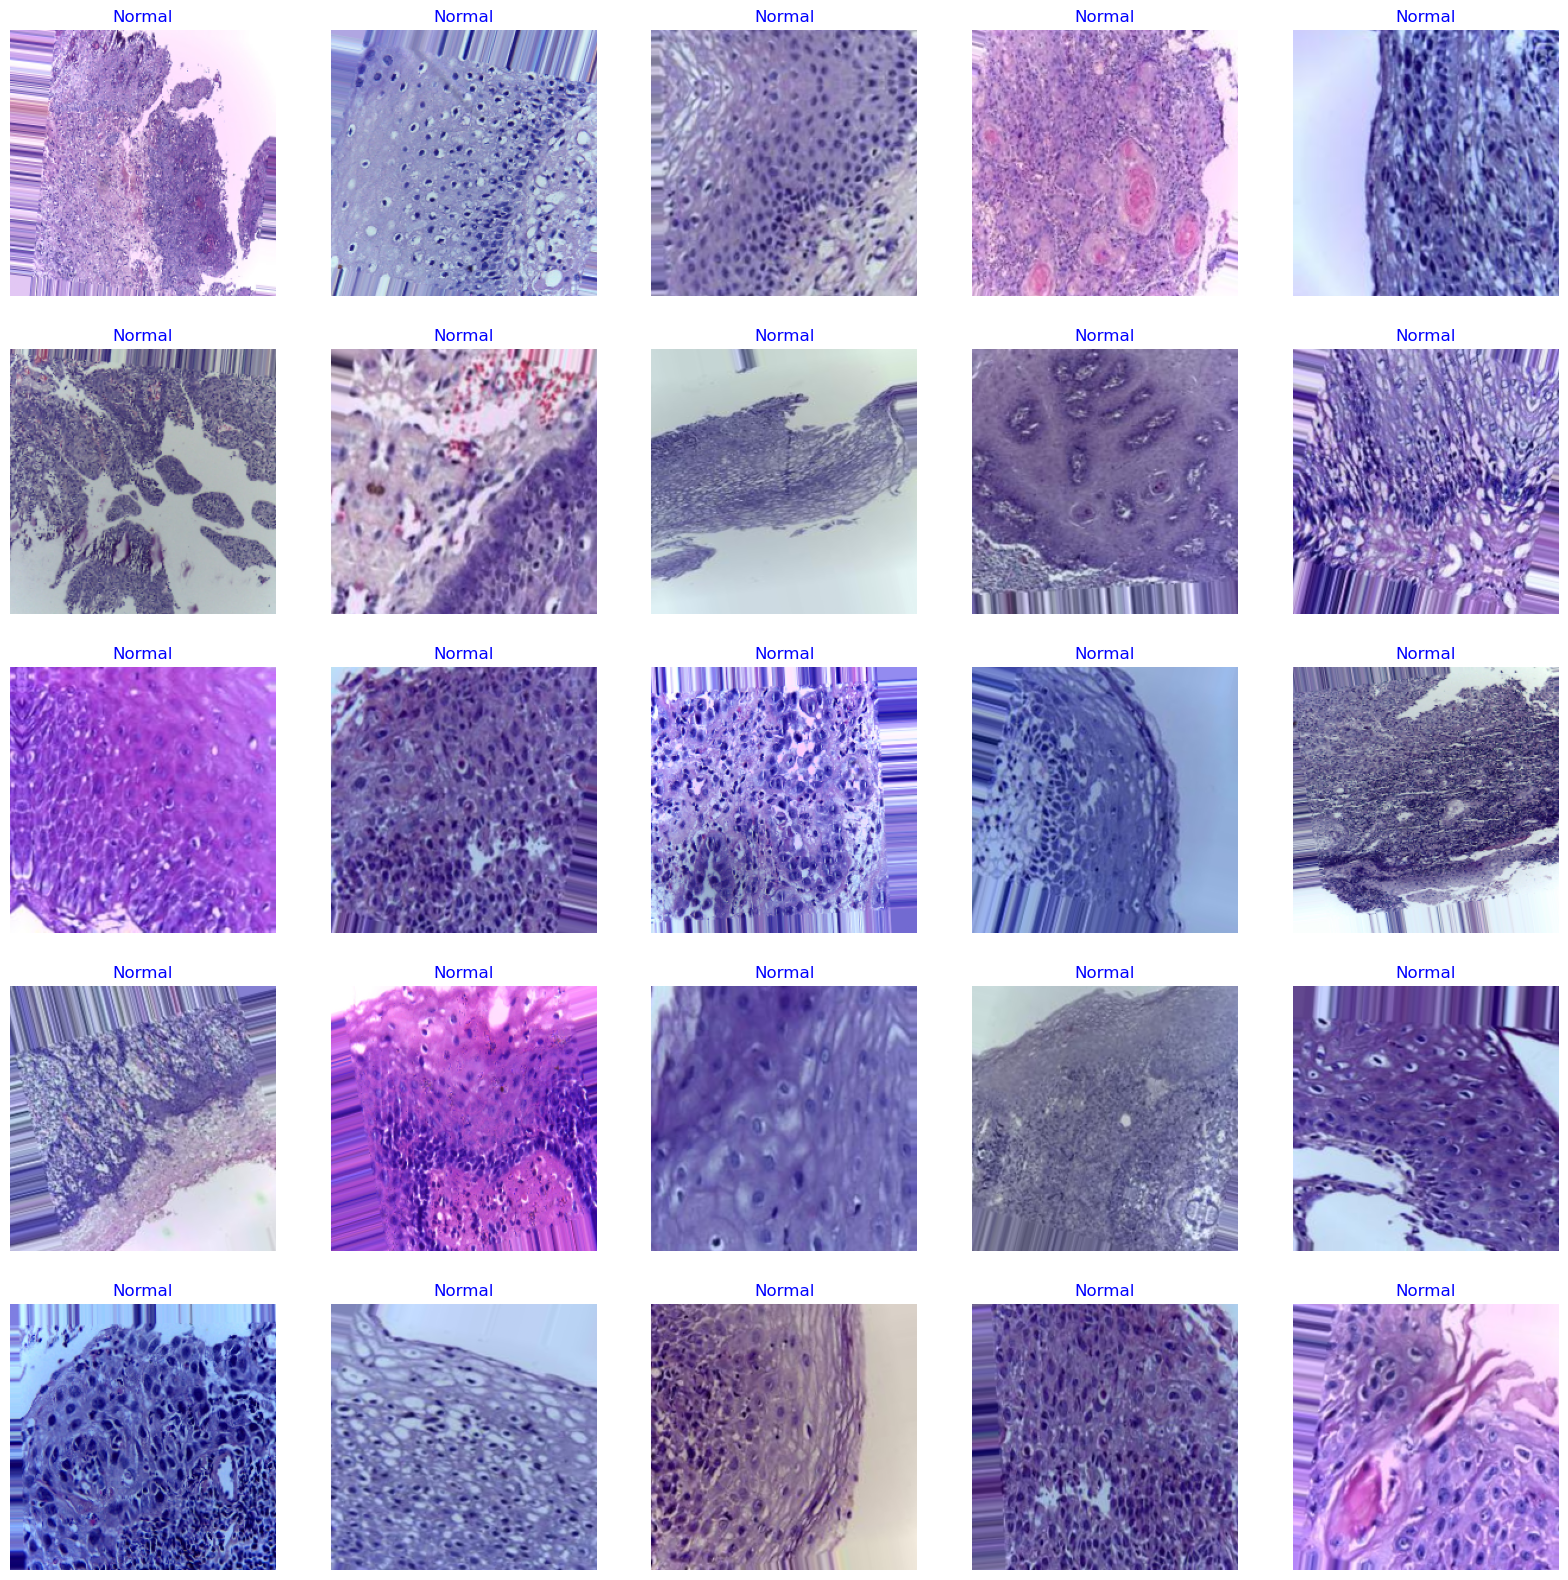

In [5]:
show_images(train_generator)

In [6]:
# Setting the base model
base_for_model = tf.keras.applications.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
for layer in base_for_model.layers:
    layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [7]:
# Build the model architecture
model = Sequential()
model.add(base_for_model) 
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(GlobalMaxPooling2D()) 
model.add(BatchNormalization())
model.add(Dense(512, activation = 'relu')) 
model.add(BatchNormalization()) 
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense (Dense)               (None, 7, 7, 512)         262656    
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 7, 7, 512)         262656    
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2

In [8]:
# Define the F1 score metric
def f1_score_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return 2 * tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())


In [9]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy','Precision','Recall','AUC',f1_score_metric]
)

In [10]:
# Train the model
history=model.fit(
    train_generator,
    epochs=10,
    batch_size=64,
    validation_data=validation_generator
)

Epoch 1/10
155/155 [==============================] - 197s 1s/step - loss: 0.5971 - accuracy: 0.7319 - precision: 0.7410 - recall: 0.7256 - auc: 0.8103 - f1_score_metric: 0.7293 - val_loss: 0.7146 - val_accuracy: 0.7833 - val_precision: 0.8056 - val_recall: 0.9457 - val_auc: 0.7512 - val_f1_score_metric: 0.8659
Epoch 2/10
155/155 [==============================] - 119s 769ms/step - loss: 0.3808 - accuracy: 0.8360 - precision: 0.8484 - recall: 0.8244 - auc: 0.9131 - f1_score_metric: 0.8353 - val_loss: 0.5764 - val_accuracy: 0.7750 - val_precision: 0.8736 - val_recall: 0.8261 - val_auc: 0.8172 - val_f1_score_metric: 0.8471
Epoch 3/10
155/155 [==============================] - 118s 761ms/step - loss: 0.2908 - accuracy: 0.8769 - precision: 0.8875 - recall: 0.8674 - auc: 0.9490 - f1_score_metric: 0.8748 - val_loss: 0.4394 - val_accuracy: 0.8333 - val_precision: 0.8830 - val_recall: 0.9022 - val_auc: 0.8818 - val_f1_score_metric: 0.8928
Epoch 4/10
155/155 [==============================] - 1

In [11]:
score=model.evaluate(validation_generator)
score

4/4 [==============================] - 7s 2s/step - loss: 0.6177 - accuracy: 0.8500 - precision: 0.8776 - recall: 0.9348 - auc: 0.8438 - f1_score_metric: 0.9042


[0.6176891922950745,
 0.8500000238418579,
 0.8775510191917419,
 0.9347826242446899,
 0.84375,
 0.9041888117790222]

**Title: Prediction of Oral Cancer using VGG16 CNN**

**Introduction:**

Oral cancer is a severe health concern worldwide, and early detection plays a crucial role in improving patient outcomes. In this study, we propose a deep learning model based on the VGG16 convolutional neural network (CNN) architecture for predicting oral cancer. By leveraging the power of deep learning and image analysis, our goal is to develop an accurate and efficient tool for oral cancer detection.

**METHODOLOGY:**

1) **Dataset**:

* We obtained a comprehensive dataset of oral cancer images, consisting of two classes: "cancer" and "non-cancer." The dataset was curated and labeled by medical experts.


2) **Data Preprocessing:**
*  To enhance the model's performance and prevent overfitting, we applied various data preprocessing techniques. These included image augmentation, such as rotation, shear, zoom, horizontal flip, and brightness adjustments. We also split the dataset into training, validation, and testing sets.


3) **Model Architecture:**

* We chose the VGG16 architecture as our base model due to its excellent performance in image classification tasks. The VGG16 model was pre-trained on the ImageNet dataset, which provides a strong foundation for feature extraction. We modified the architecture by adding additional layers to fine-tune the model for oral cancer detection.


4) **Training and Evaluation:**

* The model was trained using the training set and validated using the validation set. We utilized the Adam optimizer with a binary cross-entropy loss function. During training, we monitored various evaluation metrics, including accuracy, precision, recall, and area under the curve (AUC), to assess the model's performance.

5) **Results:**
* The trained model achieved promising results in predicting oral cancer. We observed an accuracy of 0.8583333492279053, precision of 0.8865979313850403, recall of 0.9347826242446899, AUC of 0.8544255495071411 and an F1_Score of 0.9041888117790222. These results indicate the model's ability to classify oral cancer accurately.


**Conclusion:**

In this study, we developed a deep learning model based on the VGG16 CNN architecture for the prediction of oral cancer. The model demonstrated robust performance, leveraging its ability to extract meaningful features from oral cancer images. This research contributes to the field of medical imaging and provides a potential tool for early detection of oral cancer. Further studies and improvements on this model can lead to advancements in the diagnosis and treatment of oral cancer.

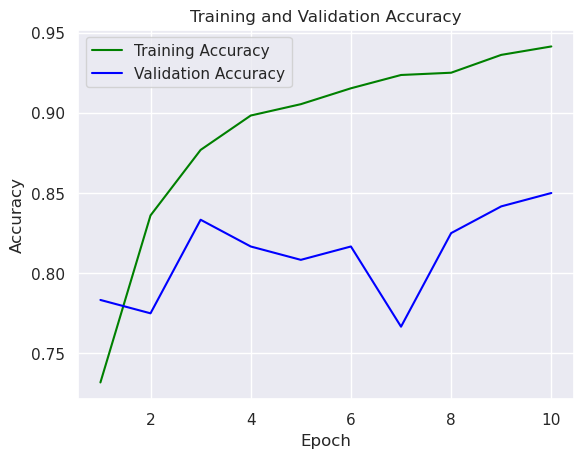

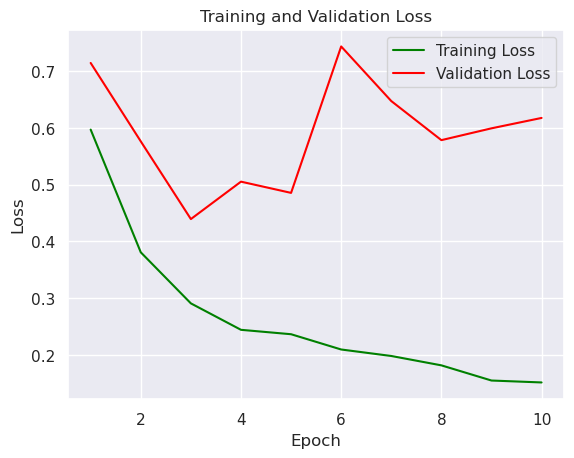

In [12]:
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()